In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as st
from math import sqrt
from IPython.display import Latex,display,Math
print("Modules Imported!")

Modules Imported!


# Stationary distributions of Markov chains
In this excercise, let 
$$P=\left[\begin{array}{cc}
\frac{1}{2} & \frac{1}{2}\\
\frac{1}{3} & \frac{2}{3}
\end{array}\right]$$
denote the transition matrix of a Markov chain with two states $\{W,S\}$. Let $X_n$ denote the state of the Markov chain at time $n$. For example, $Pr(X_n=W|X_{n-1}=S)=\frac13$. Recall that if $\pi^{(n)}$ denotes the distribution of $X_n$, we have $\pi^{(n+1)}=\pi^{(n)}P$. Note that the MC is regular. So it has a unique stationary distribution $\phi$. Observe that the stationary distribution is the left [eigenvector](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) for eigenvalue 1).

_____________
We find the eigenvalues and eigenvectors of $P$. To do this, use [`numpy.linalg`](https://docs.scipy.org/doc/numpy/reference/routines.linalg.html): 
``` python
import numpy.linalg as la
```
and then use [`numpy.linalg.eig`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html#numpy.linalg.eig):
``` python
w,v = la.eig(P.T)
```
to get the eigenvaules/vectors. Find the eigenvector that corresponds to the eigenvalue 1. To do so, make sure you understand the output format of `eig`. Normalize this eigenvector such that it sums to 1 and verify that we indeed have $\phi=\phi P$ (use `np.dot(phi,P)`).

In [2]:
import numpy.linalg as la
P=np.array([[1/2,1/2],[1/3,2/3]])
w,v = la.eig(P.T)
print(w)
print(v)

[0.16666667 1.        ]
[[-0.70710678 -0.5547002 ]
 [ 0.70710678 -0.83205029]]


In [3]:
phi = v[:,1]/sum(v[:,1])
print(phi)
print(np.dot(phi,P))

[0.4 0.6]
[0.4 0.6]


____________
Pick an arbitrary initial distribution $\pi^{(0)}$. Find $\pi^{(n)}$ for $n=0,1,2,3,4$. Does convergence to $\phi$ in fact occur? We also know that the rows of $P^n$ converge to the stationary distribution $\phi$. Verify this through computation.

In [4]:
pi = [0,1]
Pi = np.array([[1,0],[0,1]])
P=np.array([[1/2,1/2],[1/3,2/3]])
for i in range(5):
    display(Math(r'P^{%i}='%i))
    print(Pi)
    display(Math(r'\pi^{(%i)}='%i))
    print(pi,"\n------")
    Pi = np.dot(Pi,P)
    pi = np.dot(pi,P)

<IPython.core.display.Math object>

[[1 0]
 [0 1]]


<IPython.core.display.Math object>

[0, 1] 
------


<IPython.core.display.Math object>

[[0.5        0.5       ]
 [0.33333333 0.66666667]]


<IPython.core.display.Math object>

[0.33333333 0.66666667] 
------


<IPython.core.display.Math object>

[[0.41666667 0.58333333]
 [0.38888889 0.61111111]]


<IPython.core.display.Math object>

[0.38888889 0.61111111] 
------


<IPython.core.display.Math object>

[[0.40277778 0.59722222]
 [0.39814815 0.60185185]]


<IPython.core.display.Math object>

[0.39814815 0.60185185] 
------


<IPython.core.display.Math object>

[[0.40046296 0.59953704]
 [0.39969136 0.60030864]]


<IPython.core.display.Math object>

[0.39969136 0.60030864] 
------


__Sampling from Markov Chains:__ Suppose that we need to generate iid (independent and identically distributed) random samples from a given distribution $q$. Sometimes, it is difficult to do this directly, but we can construct a Markov chain whose stationary distribution is $q$. Then we can simulate this Markov chain and sample from it. Technically speaking, these samples are identically distributed but not independent. However, if there is enough of a gap between consecutive samples, they are "approximately" independent. For example, in the above Markov chain, if we take a sample at $n=3,6,9,\dotsc$, we get nearly independent samples since $\pi P^3\simeq \phi$ for any $\pi$. (In practice we may decide to use all samples since dropping samples has a computational cost.)

Simulate the above Markov chain by starting from an arbitrary state and take 1000 samples at steps that are multiples of 3. Verify that the distribution of these samples is the same as $\phi$.

_Hint_: Randomly transitioning to the next state where the trasition probabilities for the current state are given by $p$ is equivalent to generating a random variable that is equal to $i$ with probability $p_i$, which can be done as follows (why?):
```python
r = st.uniform.rvs()
rv = np.sum(r>np.cumsum(p))
```

In [5]:
def sample_MC(P,N,skip):
    M = len(P)
    y = [0] * N # initializing the vector of samples
    state = 0 # starting the chain from state 0
    for i in range(N):
        for j in range(skip):
            p = P[state,:]
            r = st.uniform.rvs()
            state = np.sum(r>np.cumsum(p))
        y[i] = state
    return(y)

In [6]:
y = sample_MC(P,1000,3)
print('The distribution is characterized by its mean, which is 0.6')
print('The mean of the samples from the MC is',sum(y)/len(y))

The distribution is characterized by its mean, which is 0.6
The mean of the samples from the MC is 0.586


<hr />

### Gibbs, Metropolis, Hamiltonian Metropolis Sampling
We will implement several MCMC sampling algorithms and compare and contrast their performance. To make things simple, the code for everything except the sampling algorithms are given. You should review and understand all the given code and make sure the code you write is compatible.

<hr />

__Setting up target distributions:__ First, we will define three python functions representing our target distributions, which are
- $p_0$: a 2-d multivarate normal (__MVN__) with independent components,
- $p_1$: a 2-d MVN with highly dependant components, and
- $p_2$: a 2-d mixture of two MVNs.

We have chosen 2-d targets to make it easier to plot the results.

In [7]:
m = np.empty([4,2]); c = np.empty([4,2,2])

m[0] = [0,0]; c[0] = [[1,0],[0,1]]

m[1] = [0,0]; c[1] = 2*np.array([[1,0.98],[.98,1]])


m[2] = [-1,-1]; c[2] = [[.7,.3],[.3,.7]]
m[3] = [ 1, 1]; c[3] = [[.7,.3],[.3,.7]]

def p0(th):
    rv = st.multivariate_normal(mean=m[0],cov=c[0])
    grad = np.dot(th,np.linalg.inv(c[0])) # Note how the gradient is computed
    return [rv.pdf(th),grad]

def p1(th):
    rv = st.multivariate_normal(mean=m[1],cov=c[1])
    grad = np.dot(th,np.linalg.inv(c[1]))
    return [rv.pdf(th),grad]

def p2(th):
    rv1 = st.multivariate_normal(mean=m[2],cov=c[2])
    rv2 = st.multivariate_normal(mean=m[3],cov=c[3])
    return [rv1.pdf(th)+rv2.pdf(th), np.nan]

pp = [p0,p1,p2]

<hr/>
We will plot the mixture target distribution using contourf:

In [8]:
p0([1.5,1.5])

[0.016774807587073417, array([1.5, 1.5])]

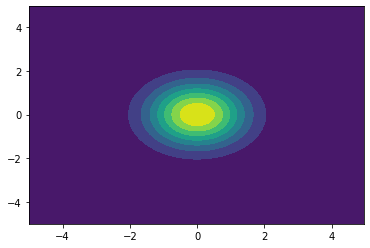

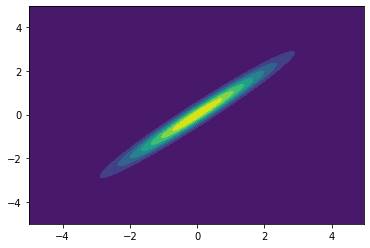

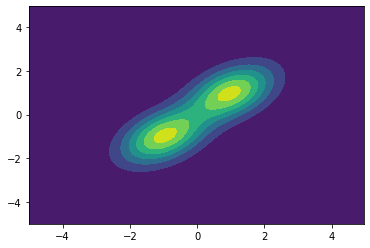

In [9]:
x,y = np.mgrid[-5:5:.05,-5:5:.05]
pos = np.empty(x.shape + (2,)) # the comma ensure (2,) is interpreted as tuple, (2) would be int
pos[:,:,0] = x; pos[:,:,1] = y
for p in pp:
    plt.figure()
    plt.contourf(x,y,p(pos)[0])

<hr>

__Sampling methods:__ Implement a Gibbs sampler, a metropolis sampler, and a Hamiltonian metropolis sampler.

For the metropolis algorithm, use a Normal jump distribution. The covariance of the jump distribution is passed to the functions as an argument. The metropolis algorithm should work for all three targets.

Implement the Gibbs and the HMC samplers for 2-d MVNs. So it only needs to work with $p_0$ and $p_1$ but not the mixture $p_2$. Note that the functions for $p_0$ and $p_1$ given above also pass the gradient in addition to the value of the pdf.

In [10]:
# metropolis with normal jumps
def metropolis(target_p, covJump, init, N_samples):
    # covJump: the covariance of the mustivariate normal jumping distn
    # target_p is the target distribution from which we want to sample. this is a function
    # N_samples is the number of samples we want
    # th = np.empty((N,len(init))) ## th will hold the samples that we generate
    # th[0] = init ## the starting point, i.e., the first sample
    jump_rv = st.multivariate_normal(np.zeros(init.shape), covJump)
    p = target_p
    N = N_samples
    th = np.empty((N,len(init)))
    th[0] = init
    
    for i in range(1,N):
        th_prpsl = th[i-1] + jump_rv.rvs()
        u = st.uniform.rvs()
        if p(th_prpsl)[0] > u * p(th[i-1])[0]:
            th[i] = th_prpsl # accept
        else:
            th[i] = th[i-1]
    return th

In [11]:
# Gibbs for 2-d normal
def Gibbs_normal(mean, cov, init, N_samples):
    # mean: mean of the target MVN distribution
    # cov: covariance of the target MVN
    # th = np.empty([N,2])
    # th[0] = init
    N = N_samples
    th = np.empty([N,2])
    th[0] = init
    sigma = [np.sqrt(cov[0,0]),np.sqrt(cov[1,1])]
    rho = cov[0,1]/(sigma[0]*sigma[1])
    for i in range(1,N):
        j = i%2
        th[i] = th[i-1]
        th[i,j] = st.norm.rvs(
            loc   = mean[j]+rho*sigma[j]/sigma[1-j]*(th[i,1-j]-mean[1-j]),
            scale = np.sqrt((1-rho**2))*sigma[j],size=1)[0]
    return th

In [12]:
# HMC with standard normal momentum proposal, refer to McKay, "Information Theory, Inference, and Learning Algorithms"
def HMC(target_p, eps, L, init, N_samples,):
    # eps is the scale of each leapfrog step
    # L is the number of leapfrog steps in each iteration
    # target_p(theta) returns [pdf, gradient] for the point theta
    # momentum_rv = ... ## proposal rv for momentum is a standard 2-d MVN
    # th = np.empty((N,len(init)))
    momentum_rv = st.multivariate_normal(np.zeros(len(init)), np.eye(len(init))) # proposal rv for momentum
    p = target_p
    N = N_samples
    th_samples = np.empty((N,len(init)))
    th = init
    th_samples[0] = init
    g = p(th)[1] # set gradient using initial th
    E = np.log(p(th)[0]) # set objective function too
    
    for n in range(1,N): # N samples
        mtm = momentum_rv.rvs() # initial momentum is Normal(0,1)
        H = -np.dot(mtm,mtm) / 2 + E ; # evaluate H(theha,momentum)
        th_new = th ; gnew = g ;
        for i in range(L): # make L `leapfrog' steps
            mtm = mtm - eps * gnew / 2 ; # make half-step in momentum
            th_new = th_new + eps * mtm ; # make step in theta
            gnew = p(th_new)[1] ; # find new gradient
            mtm = mtm - eps * gnew / 2 ; # make half-step in momentum
            
        Enew = np.log(p(th_new)[0]); # find new value of E
        Hnew = np.dot(mtm,mtm) / 2 + Enew ;
        dH = Hnew - H ; # Decide whether to accept
        if st.uniform.rvs() < np.exp(dH):
            th = th_new; g = gnew; E = Enew
            
        th_samples[n] = th
    return th_samples



__Comparison of sampling methods:__ We now plot the samples obtained using each method for four random starting point. You need to run this 3 times to see the result for each of the targets. Note that Metropolis is the only method implemented here to handle $p_2$. Try different numbers of samples and a variety of values for the other parameters and compare the results of the methods. Describe the differences between the sampling methods based on this observations in a couple of paragraphs.

[-0.07935038 -0.58554819] 
 [[ 1.7497413  -0.23545753]
 [-0.23545753  1.29000988]] --

[-0.1986414   0.23678428] 
 [[ 1.30781068 -0.24401295]
 [-0.24401295  1.43023972]] --

[0.41522555 0.05212433] 
 [[1.39853702 0.299853  ]
 [0.299853   1.55923021]] --

[ 0.03708716 -0.12333216] 
 [[1.1382607  0.6720616 ]
 [0.6720616  0.96272532]] --

==

[-0.05224198  0.05965141] 
 [[ 1.00366848e+00 -6.58877940e-04]
 [-6.58877940e-04  9.80431680e-01]] --

[-0.0130286  0.0359367] 
 [[ 0.94657738 -0.00835408]
 [-0.00835408  0.93570064]] --

[ 0.03317567 -0.0573366 ] 
 [[0.99922263 0.03676659]
 [0.03676659 0.92966586]] --

[-0.06999806  0.04415777] 
 [[0.98877999 0.02239894]
 [0.02239894 0.99152601]] --

==

[0.01738489 0.05239911] 
 [[ 1.06406137 -0.00296903]
 [-0.00296903  0.9911165 ]] --

[ 0.03379679 -0.04902097] 
 [[ 0.99047373 -0.04176226]
 [-0.04176226  1.06493667]] --

[-0.04701112 -0.00807702] 
 [[ 1.06004412 -0.00356207]
 [-0.00356207  0.85515823]] --

[ 0.01972611 -0.00343681] 
 [[1.02777391 

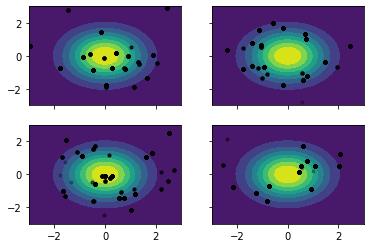

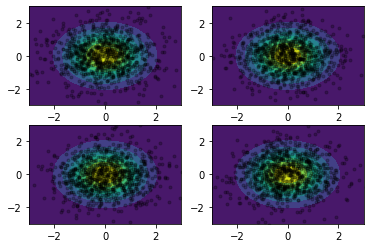

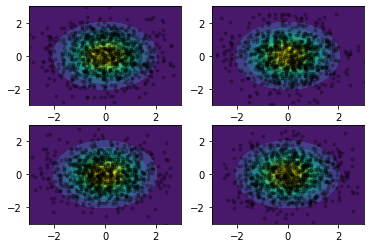

In [18]:
# target distn

i = 0  # __Also try i = 1 and i = 2
p = pp[i]
N = 1000
alpha = .25

# the parameteres of the jumping distn
covJump = np.array([[1,0],[0,1]])
scale = 100
plot = True
# Metropolis
f, ax = plt.subplots(2,2, sharex='col', sharey='row')
for j in range(2):
    for k in range(2):
        init = st.uniform.rvs(-2,2,2)
        th = metropolis(p, scale*covJump, init, N)
        print(np.mean(th,0),'\n',np.cov(th.T),'--\n')
        if plot:
            plt.axes(ax[j][k])
            plt.axis([-3,3,-3,3])
            plt.contourf(x,y,p(pos)[0])
            plt.plot(th[:,0],th[:,1],'k.',alpha=alpha)
            plt.savefig('Met.pdf')
        # with small number of samples try also ':k.' to see the order of samples
print('==\n')
if i == 0 or i == 1:
    # HMC
    f, ax = plt.subplots(2,2)
    for j in range(2):
        for k in range(2):
            init = st.uniform.rvs(-2,2,2)
            th = HMC(p, 0.1, 10, init, N)
            print(np.mean(th,0),'\n',np.cov(th.T),'--\n')
            if plot:
                plt.axes(ax[j][k])
                plt.axis([-3,3,-3,3])
                plt.contourf(x,y,p(pos)[0])
                plt.plot(th[:,0],th[:,1],'k.',alpha=alpha)
                plt.savefig('HMC.pdf')
    print('==\n')        
    # Gibbs
    f, ax = plt.subplots(2,2)
    for j in range(2):
        for k in range(2):
            init = st.uniform.rvs(-2,2,2)
            th = Gibbs_normal(m[i], c[i], init, N)
            print(np.mean(th,0),'\n',np.cov(th.T),'--\n')
            if plot:
                plt.axes(ax[j][k])
                plt.axis([-3,3,-3,3])
                plt.contourf(x,y,p(pos)[0])
                plt.plot(th[:,0],th[:,1],'k.',alpha=alpha) 
                plt.savefig('Gibbs.pdf')

In [19]:
print(np.mean(th,0),'\n',np.cov(th.T),'--\n')

[ 0.01972611 -0.00343681] 
 [[1.02777391 0.03795615]
 [0.03795615 1.01490974]] --



In [15]:
# For i = 0, if we had plotted every other sample, Gibbs would have given optimal results (no
# dependence between the dimensions). HMC seems to perform very well too.
# Specifically for Metropolis, it is clear that 100 samples is not enough. You can see from the
# next set of figures that it works much better with 500 samples.

[-0.83354653  0.00164324] 
 [[1.09066548 0.73156442]
 [0.73156442 1.64660112]] --

[ 0.12517256 -0.06535174] 
 [[ 0.54897522 -0.07357354]
 [-0.07357354  0.40429686]] --

[ 0.2456304  -0.28397162] 
 [[2.01127868 0.80022663]
 [0.80022663 1.49638967]] --

[0.0043401  0.03009583] 
 [[ 0.49330934 -0.04618913]
 [-0.04618913  0.77194686]] --

==

[ 0.0016427  -0.07782022] 
 [[0.99194249 0.1029674 ]
 [0.1029674  1.05669565]] --

[-0.00774359  0.07084403] 
 [[ 0.87230913 -0.03299932]
 [-0.03299932  0.91427813]] --

[ 0.01022654 -0.06476252] 
 [[1.10517485 0.01224524]
 [0.01224524 0.90438891]] --

[ 0.07569316 -0.04810638] 
 [[ 0.97845911 -0.0445309 ]
 [-0.0445309   0.98259927]] --

==

[ 0.03476599 -0.08198626] 
 [[1.09547557 0.01799712]
 [0.01799712 0.93638758]] --

[ 0.01953049 -0.02132154] 
 [[ 0.97991558 -0.00979202]
 [-0.00979202  1.0074591 ]] --

[-0.07274646  0.02912709] 
 [[0.98419811 0.03700183]
 [0.03700183 1.05882286]] --

[-0.10897252  0.0313261 ] 
 [[ 0.8832626  -0.0195084 ]
 [-0.0

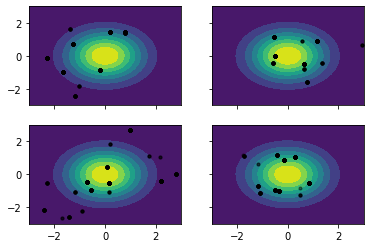

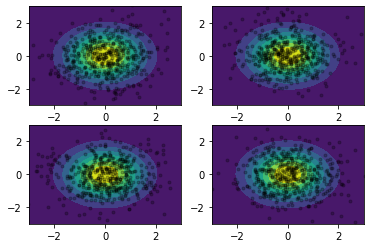

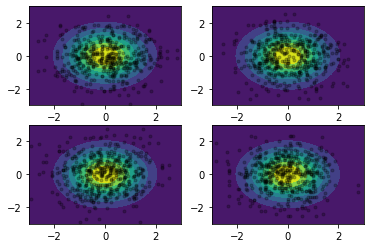

In [20]:
# i = 0, N = 500
i = 0
p = pp[i]
N = 500
alpha = .25

# the parameteres of the jumping distn
covJump = np.array([[1,0],[0,1]])
scale = 100
plot = True
# Metropolis
f, ax = plt.subplots(2,2, sharex='col', sharey='row')
for j in range(2):
    for k in range(2):
        init = st.uniform.rvs(-2,2,2)
        th = metropolis(p, scale*covJump, init, N)
        print(np.mean(th,0),'\n',np.cov(th.T),'--\n')
        if plot:
            plt.axes(ax[j][k])
            plt.axis([-3,3,-3,3])
            plt.contourf(x,y,p(pos)[0])
            plt.plot(th[:,0],th[:,1],'k.',alpha=alpha)
            plt.savefig('Met.pdf')
        # with small number of samples try also ':k.' to see the order of samples
print('==\n')
if i == 0 or i == 1:
    # HMC
    f, ax = plt.subplots(2,2)
    for j in range(2):
        for k in range(2):
            init = st.uniform.rvs(-2,2,2)
            th = HMC(p, 0.1, 10, init, N)
            print(np.mean(th,0),'\n',np.cov(th.T),'--\n')
            if plot:
                plt.axes(ax[j][k])
                plt.axis([-3,3,-3,3])
                plt.contourf(x,y,p(pos)[0])
                plt.plot(th[:,0],th[:,1],'k.',alpha=alpha)
                plt.savefig('HMC.pdf')
    print('==\n')        
    # Gibbs
    f, ax = plt.subplots(2,2)
    for j in range(2):
        for k in range(2):
            init = st.uniform.rvs(-2,2,2)
            th = Gibbs_normal(m[i], c[i], init, N)
            print(np.mean(th,0),'\n',np.cov(th.T),'--\n')
            if plot:
                plt.axes(ax[j][k])
                plt.axis([-3,3,-3,3])
                plt.contourf(x,y,p(pos)[0])
                plt.plot(th[:,0],th[:,1],'k.',alpha=alpha) 
                plt.savefig('Gibbs.pdf')
print(np.mean(th,0),'\n',np.cov(th.T),'--\n')

[-1.53757532 -1.53235768] 
 [[0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99207299e-31]] --

[-3.62875449 -3.12994163] 
 [[2.6005481  3.22853205]
 [3.22853205 4.00816244]] --

[-1.942143   -1.01048405] 
 [[7.17146277e-30 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]] --

[-2.24006292 -1.56928904] 
 [[0.47552542 0.04422483]
 [0.04422483 0.0435735 ]] --

==

[-0.71357811 -0.75623806] 
 [[2.61600688 2.63224407]
 [2.63224407 2.73347393]] --

[0.21962485 0.2342212 ] 
 [[2.28606034 2.37323245]
 [2.37323245 2.56889762]] --

[-0.61947404 -0.65263124] 
 [[1.37894387 1.3661846 ]
 [1.3661846  1.42354969]] --

[-0.00541019  0.01421841] 
 [[1.66708029 1.61640253]
 [1.61640253 1.65591661]] --

==

[0.0208356  0.01548856] 
 [[0.39436102 0.38284724]
 [0.38284724 0.42851625]] --

[-1.16563272 -1.19385276] 
 [[0.49606447 0.45991404]
 [0.45991404 0.49912426]] --

[0.24828207 0.24155821] 
 [[3.58134874 3.48506286]
 [3.48506286 3.48480265]] --

[0.16882849 0.20733716] 
 [[0.88531984 0.82729642]
 [

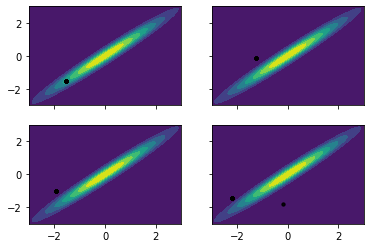

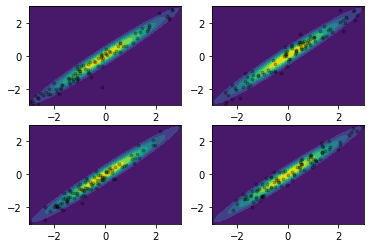

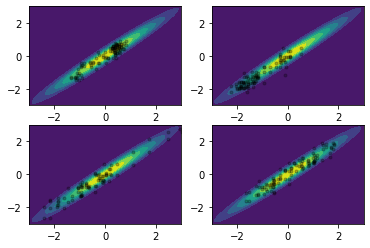

In [21]:
# i = 1, N = 100
# The situation becomes worse for Metropolis, and here is where we see the real advantage of HMC,
# since even for N=500, Metropolis does not perform very well. 

i = 1
p = pp[i]
N = 100
alpha = .25

# the parameteres of the jumping distn
covJump = np.array([[1,0],[0,1]])
scale = 100
plot = True
# Metropolis
f, ax = plt.subplots(2,2, sharex='col', sharey='row')
for j in range(2):
    for k in range(2):
        init = st.uniform.rvs(-2,2,2)
        th = metropolis(p, scale*covJump, init, N)
        print(np.mean(th,0),'\n',np.cov(th.T),'--\n')
        if plot:
            plt.axes(ax[j][k])
            plt.axis([-3,3,-3,3])
            plt.contourf(x,y,p(pos)[0])
            plt.plot(th[:,0],th[:,1],'k.',alpha=alpha)
            plt.savefig('Met.pdf')
        # with small number of samples try also ':k.' to see the order of samples
print('==\n')
if i == 0 or i == 1:
    # HMC
    f, ax = plt.subplots(2,2)
    for j in range(2):
        for k in range(2):
            init = st.uniform.rvs(-2,2,2)
            th = HMC(p, 0.1, 10, init, N)
            print(np.mean(th,0),'\n',np.cov(th.T),'--\n')
            if plot:
                plt.axes(ax[j][k])
                plt.axis([-3,3,-3,3])
                plt.contourf(x,y,p(pos)[0])
                plt.plot(th[:,0],th[:,1],'k.',alpha=alpha)
                plt.savefig('HMC.pdf')
    print('==\n')        
    # Gibbs
    f, ax = plt.subplots(2,2)
    for j in range(2):
        for k in range(2):
            init = st.uniform.rvs(-2,2,2)
            th = Gibbs_normal(m[i], c[i], init, N)
            print(np.mean(th,0),'\n',np.cov(th.T),'--\n')
            if plot:
                plt.axes(ax[j][k])
                plt.axis([-3,3,-3,3])
                plt.contourf(x,y,p(pos)[0])
                plt.plot(th[:,0],th[:,1],'k.',alpha=alpha) 
                plt.savefig('Gibbs.pdf')
print(np.mean(th,0),'\n',np.cov(th.T),'--\n')

[-0.60674053 -0.59430254] 
 [[3.1526117  3.01991197]
 [3.01991197 3.11021575]] --

[0.91911281 1.03069436] 
 [[1.64950493 1.22826965]
 [1.22826965 0.95183753]] --

[1.62542526 1.43135192] 
 [[1.17370433 1.34524122]
 [1.34524122 1.55669873]] --

[-0.01251716 -0.20299208] 
 [[1.66746617 1.23909131]
 [1.23909131 1.00116533]] --

==

[-0.23448981 -0.24696204] 
 [[2.51008214 2.4568525 ]
 [2.4568525  2.48431842]] --

[0.06670358 0.02944768] 
 [[1.80695164 1.75635603]
 [1.75635603 1.78923037]] --

[-0.17753715 -0.17930907] 
 [[1.93929577 1.86031596]
 [1.86031596 1.86543256]] --

[-0.23687659 -0.25166908] 
 [[2.04502337 2.03174975]
 [2.03174975 2.11532586]] --

==

[0.40434899 0.41000133] 
 [[1.3255501  1.28386093]
 [1.28386093 1.32556159]] --

[0.47088357 0.49836534] 
 [[1.73714222 1.74244685]
 [1.74244685 1.83236382]] --

[0.0351862  0.05519933] 
 [[0.76735982 0.73656659]
 [0.73656659 0.79392402]] --

[-0.42191079 -0.40744601] 
 [[1.73908956 1.66033654]
 [1.66033654 1.66954743]] --

[-0.4219

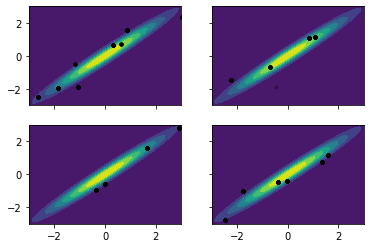

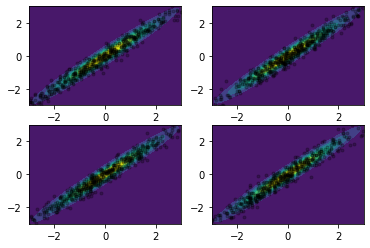

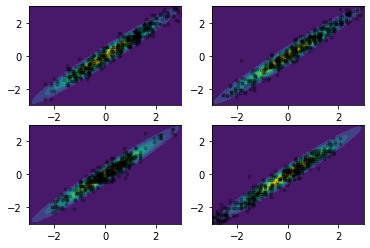

In [22]:
# i=1, N=500

i = 1
p = pp[i]
N = 500
alpha = .25

# the parameteres of the jumping distn
covJump = np.array([[1,0],[0,1]])
scale = 100
plot = True
# Metropolis
f, ax = plt.subplots(2,2, sharex='col', sharey='row')
for j in range(2):
    for k in range(2):
        init = st.uniform.rvs(-2,2,2)
        th = metropolis(p, scale*covJump, init, N)
        print(np.mean(th,0),'\n',np.cov(th.T),'--\n')
        if plot:
            plt.axes(ax[j][k])
            plt.axis([-3,3,-3,3])
            plt.contourf(x,y,p(pos)[0])
            plt.plot(th[:,0],th[:,1],'k.',alpha=alpha)
            plt.savefig('Met.pdf')
        # with small number of samples try also ':k.' to see the order of samples
print('==\n')
if i == 0 or i == 1:
    # HMC
    f, ax = plt.subplots(2,2)
    for j in range(2):
        for k in range(2):
            init = st.uniform.rvs(-2,2,2)
            th = HMC(p, 0.1, 10, init, N)
            print(np.mean(th,0),'\n',np.cov(th.T),'--\n')
            if plot:
                plt.axes(ax[j][k])
                plt.axis([-3,3,-3,3])
                plt.contourf(x,y,p(pos)[0])
                plt.plot(th[:,0],th[:,1],'k.',alpha=alpha)
                plt.savefig('HMC.pdf')
    print('==\n')        
    # Gibbs
    f, ax = plt.subplots(2,2)
    for j in range(2):
        for k in range(2):
            init = st.uniform.rvs(-2,2,2)
            th = Gibbs_normal(m[i], c[i], init, N)
            print(np.mean(th,0),'\n',np.cov(th.T),'--\n')
            if plot:
                plt.axes(ax[j][k])
                plt.axis([-3,3,-3,3])
                plt.contourf(x,y,p(pos)[0])
                plt.plot(th[:,0],th[:,1],'k.',alpha=alpha) 
                plt.savefig('Gibbs.pdf')
print(np.mean(th,0),'\n',np.cov(th.T),'--\n')

[-0.00642963  0.56049963] 
 [[0.28803856 0.74797089]
 [0.74797089 1.942311  ]] --

[-0.49030683 -0.79346018] 
 [[0.52101666 0.62175232]
 [0.62175232 0.7528181 ]] --

[-1.10947051 -1.82249268] 
 [[ 0.00794643 -0.00641182]
 [-0.00641182  0.00517357]] --

[ 0.89636145 -0.20450095] 
 [[1.59376159 2.768008  ]
 [2.768008   5.48319727]] --

==

[ 0.89636145 -0.20450095] 
 [[1.59376159 2.768008  ]
 [2.768008   5.48319727]] --



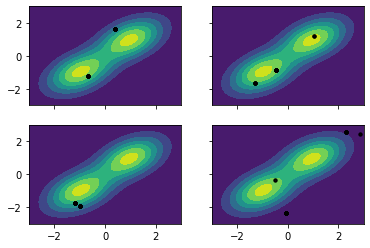

In [23]:
# i = 2, N = 100
# In more complex cases, Metropolis may be the only method that is feasible (the other methods are
# impossible for this mixture but they are not as straightforward as before). In such cases, we must
# make sure that Metropolis has converged by running parallel chains. For N=100 it is clear that 
# there is no convergence, but for N=500 the situation is better.

i = 2
p = pp[i]
N = 100
alpha = .25

# the parameteres of the jumping distn
covJump = np.array([[1,0],[0,1]])
scale = 100
plot = True
# Metropolis
f, ax = plt.subplots(2,2, sharex='col', sharey='row')
for j in range(2):
    for k in range(2):
        init = st.uniform.rvs(-2,2,2)
        th = metropolis(p, scale*covJump, init, N)
        print(np.mean(th,0),'\n',np.cov(th.T),'--\n')
        if plot:
            plt.axes(ax[j][k])
            plt.axis([-3,3,-3,3])
            plt.contourf(x,y,p(pos)[0])
            plt.plot(th[:,0],th[:,1],'k.',alpha=alpha)
            plt.savefig('Met.pdf')
        # with small number of samples try also ':k.' to see the order of samples
print('==\n')
if i == 0 or i == 1:
    # HMC
    f, ax = plt.subplots(2,2)
    for j in range(2):
        for k in range(2):
            init = st.uniform.rvs(-2,2,2)
            th = HMC(p, 0.1, 10, init, N)
            print(np.mean(th,0),'\n',np.cov(th.T),'--\n')
            if plot:
                plt.axes(ax[j][k])
                plt.axis([-3,3,-3,3])
                plt.contourf(x,y,p(pos)[0])
                plt.plot(th[:,0],th[:,1],'k.',alpha=alpha)
                plt.savefig('HMC.pdf')
    print('==\n')        
    # Gibbs
    f, ax = plt.subplots(2,2)
    for j in range(2):
        for k in range(2):
            init = st.uniform.rvs(-2,2,2)
            th = Gibbs_normal(m[i], c[i], init, N)
            print(np.mean(th,0),'\n',np.cov(th.T),'--\n')
            if plot:
                plt.axes(ax[j][k])
                plt.axis([-3,3,-3,3])
                plt.contourf(x,y,p(pos)[0])
                plt.plot(th[:,0],th[:,1],'k.',alpha=alpha) 
                plt.savefig('Gibbs.pdf')
print(np.mean(th,0),'\n',np.cov(th.T),'--\n')

[-0.34294301 -0.09451763] 
 [[0.54441449 0.75816183]
 [0.75816183 1.47369257]] --

[-0.16669665 -0.45171387] 
 [[0.72743079 0.46188235]
 [0.46188235 0.73900895]] --

[ 1.03137352 -0.49763881] 
 [[1.28607809 0.45473528]
 [0.45473528 1.18299646]] --

[-0.26217263 -0.12323717] 
 [[1.35737816 1.06180246]
 [1.06180246 1.04405853]] --

==

[-0.26217263 -0.12323717] 
 [[1.35737816 1.06180246]
 [1.06180246 1.04405853]] --



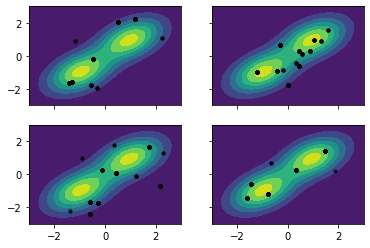

In [24]:
# i = 2, N = 500

i = 2
p = pp[i]
N = 500
alpha = .25

# the parameteres of the jumping distn
covJump = np.array([[1,0],[0,1]])
scale = 100
plot = True
# Metropolis
f, ax = plt.subplots(2,2, sharex='col', sharey='row')
for j in range(2):
    for k in range(2):
        init = st.uniform.rvs(-2,2,2)
        th = metropolis(p, scale*covJump, init, N)
        print(np.mean(th,0),'\n',np.cov(th.T),'--\n')
        if plot:
            plt.axes(ax[j][k])
            plt.axis([-3,3,-3,3])
            plt.contourf(x,y,p(pos)[0])
            plt.plot(th[:,0],th[:,1],'k.',alpha=alpha)
            plt.savefig('Met.pdf')
        # with small number of samples try also ':k.' to see the order of samples
print('==\n')
if i == 0 or i == 1:
    # HMC
    f, ax = plt.subplots(2,2)
    for j in range(2):
        for k in range(2):
            init = st.uniform.rvs(-2,2,2)
            th = HMC(p, 0.1, 10, init, N)
            print(np.mean(th,0),'\n',np.cov(th.T),'--\n')
            if plot:
                plt.axes(ax[j][k])
                plt.axis([-3,3,-3,3])
                plt.contourf(x,y,p(pos)[0])
                plt.plot(th[:,0],th[:,1],'k.',alpha=alpha)
                plt.savefig('HMC.pdf')
    print('==\n')        
    # Gibbs
    f, ax = plt.subplots(2,2)
    for j in range(2):
        for k in range(2):
            init = st.uniform.rvs(-2,2,2)
            th = Gibbs_normal(m[i], c[i], init, N)
            print(np.mean(th,0),'\n',np.cov(th.T),'--\n')
            if plot:
                plt.axes(ax[j][k])
                plt.axis([-3,3,-3,3])
                plt.contourf(x,y,p(pos)[0])
                plt.plot(th[:,0],th[:,1],'k.',alpha=alpha) 
                plt.savefig('Gibbs.pdf')
print(np.mean(th,0),'\n',np.cov(th.T),'--\n')

In conclusion, if you can implement HMC, that will likely give the best results, then Gibbs. Metropolis however is the most widely applicable methods. Also, here we did not discuss the important topic of setting the appropriate parameters for the chains. 

__corner:__ The [corner package](http://corner.readthedocs.io/en/latest/) is useful for demonstrating multivariate samples. Install it (open the Anaconda Prompt and type "pip install corner") and then run the following code. This should show the difference between Metropolis and HMC more clearly. In particular, describe the difference between the marginals.

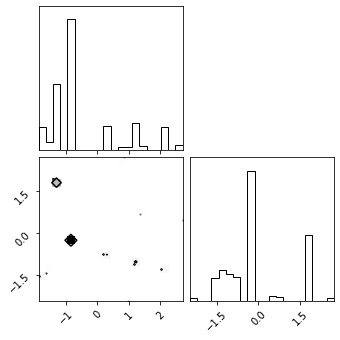

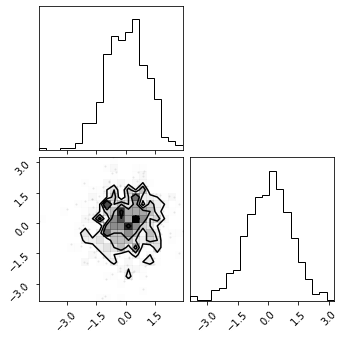

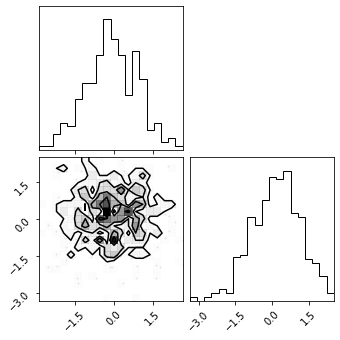

In [26]:
#!pip install corner
import corner

i=0
N = 500;
th = metropolis(pp[i], scale*covJump, init, N)
corner.corner(th);

th = HMC(pp[i], 0.1, 10, init, N)
corner.corner(th);

th = Gibbs_normal(m[i], c[i], init, N)
corner.corner(th);